In [5]:
!pip install matplotlib pyspark

In [6]:
!pip install chardet

In [7]:
import os
import pandas as pd
import chardet
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession

In [8]:
spark = SparkSession.builder \
    .appName("Image Presence and Category Trend Analysis") \
    .master("local[*]") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.extraJavaOptions", "-XX:+PrintGCDetails -XX:+PrintGCTimeStamps -Xloggc:/path/to/gc.log") \
    .getOrCreate()

24/10/14 17:17:24 WARN Utils: Your hostname, codespaces-cdb1ad resolves to a loopback address: 127.0.0.1; using 10.0.3.124 instead (on interface eth0)
24/10/14 17:17:24 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/14 17:17:25 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [9]:
csv_directory = ('../ARDataset/')

In [10]:
all_data = pd.DataFrame()
failed_files = []

In [11]:
def detect_encoding(file_path):
    """Detect the encoding of a file."""
    with open(file_path, 'rb') as f:
        result = chardet.detect(f.read(10000))  
    return result['encoding']

In [12]:
for filename in os.listdir(csv_directory):
    if filename.endswith('.csv'):
        file_path = os.path.join(csv_directory, filename)
        encoding = detect_encoding(file_path) 
        try:
            temp_data = pd.read_csv(file_path, encoding=encoding, on_bad_lines='skip')  # Skip bad lines
            all_data = pd.concat([all_data, temp_data], ignore_index=True)
            print(f"Loaded {filename} with encoding {encoding}")
        except Exception as e:
            print(f"Failed to load {filename} with detected encoding {encoding}: {e}")
            failed_files.append(filename) 

            try:
                temp_data = pd.read_csv(file_path, encoding='ISO-8859-1', on_bad_lines='skip')
                all_data = pd.concat([all_data, temp_data], ignore_index=True)
                print(f"Successfully loaded {filename} with fallback encoding ISO-8859-1")
            except Exception as e:
                print(f"Failed to load {filename} with fallback encoding: {e}")
                failed_files.append(filename) 

print("Data loaded:", all_data.shape)

Loaded part-00007-5e194d26-a8d2-4362-a3ba-8db470c839a8-c000.csv with encoding utf-8
Loaded part-00010-5e194d26-a8d2-4362-a3ba-8db470c839a8-c000.csv with encoding utf-8
Loaded part-00009-5e194d26-a8d2-4362-a3ba-8db470c839a8-c000.csv with encoding utf-8
Loaded part-00004-5e194d26-a8d2-4362-a3ba-8db470c839a8-c000.csv with encoding utf-8
Loaded part-00000-5e194d26-a8d2-4362-a3ba-8db470c839a8-c000.csv with encoding utf-8
Loaded part-00001-5e194d26-a8d2-4362-a3ba-8db470c839a8-c000.csv with encoding utf-8
Loaded part-00003-5e194d26-a8d2-4362-a3ba-8db470c839a8-c000.csv with encoding utf-8
Loaded part-00006-5e194d26-a8d2-4362-a3ba-8db470c839a8-c000.csv with encoding utf-8
Loaded part-00008-5e194d26-a8d2-4362-a3ba-8db470c839a8-c000.csv with encoding utf-8


24/10/14 17:17:38 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


Loaded part-00005-5e194d26-a8d2-4362-a3ba-8db470c839a8-c000.csv with encoding utf-8
Loaded part-00002-5e194d26-a8d2-4362-a3ba-8db470c839a8-c000.csv with encoding utf-8
Loaded part-00012-5e194d26-a8d2-4362-a3ba-8db470c839a8-c000.csv with encoding utf-8
Loaded part-00011-5e194d26-a8d2-4362-a3ba-8db470c839a8-c000.csv with encoding utf-8
Data loaded: (6391767, 4)


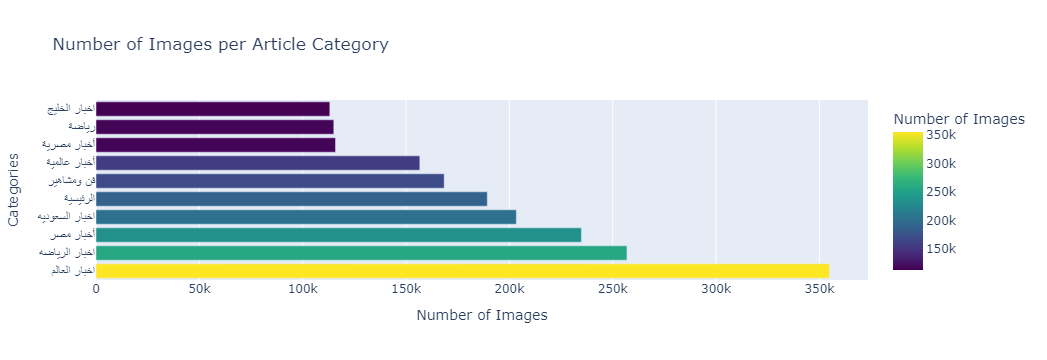

Analysis complete. Number of images per category has been plotted.


In [16]:
all_data['categories'] = all_data['categories'].astype('category')

all_data['image_present'] = all_data['image_url'].notnull() & (all_data['image_url'].str.strip() != '')
filtered_data = all_data[all_data['image_present']]

image_counts = filtered_data.groupby('categories', observed=False).size().reset_index(name='image_count')
top_n = 10 
image_counts = image_counts.nlargest(top_n, 'image_count')

import plotly.express as px

fig = px.bar(image_counts, x='image_count', y='categories', orientation='h',
             title='Number of Images per Article Category',
             labels={'categories': 'Categories', 'image_count': 'Number of Images'},
             color='image_count', 
             color_continuous_scale=px.colors.sequential.Viridis)  # Change to a valid color scale

fig.update_layout(yaxis_title='Categories', xaxis_title='Number of Images')
fig.show()

print("Analysis complete. Number of images per category has been plotted.")